In [1]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import fnmatch 
from tqdm import tqdm 
import fnmatch 
import torch 

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

av_window=4

In [3]:
from utils import save_dir, analyze_dir, result_dir
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
analyze_identifier= 'mftma-exm_per_class=50-proj=False-rand=False-kappa=0-n_t=300-n_rep=1'
train_identifier = 'epochs-10_batch-32_lr-0.001_momentum-0.5_init-gaussian_std-0.0001'

In [10]:
# load accuracy data first 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

hier_accu=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [00:20, 51.26it/s]


In [58]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches

In [12]:
# load mftma files 
data_=pickle.load(open(os.path.join(analyze_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_mftma_pooled.pkl'), 'rb'))

mftma_res=data_['mftma_results']
#if not os.path.exists(os.path.join(result_dir,analyze_identifier,model_identifier)):
#        os.makedirs(os.path.join(result_dir,analyze_identifier,model_identifier))
temp=[np.asarray([x['seq'] for x in mftma_res[y]]) for y in mftma_res.keys()]
y=temp[0]
for k in temp:
    y=np.intersect1d(y,k)

In [20]:
mftma_epochs=[np.asarray([x['epoch'] for x in mftma_res[y]]) for y in mftma_res.keys()]
mftma_batch=[np.asarray([x['batch'] for x in mftma_res[y]]) for y in mftma_res.keys()]


In [ ]:
l_num=1
layer_data=mftma_res['layer_1_Linear']
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_correspondance=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

In [87]:
layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))

corrected_data=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_correspondance):
    corrected_data[int(x)]=layer_cap[idx,:]

In [110]:
list(layer_keys)

['layer_0_Input', 'layer_1_Linear', 'layer_2_Linear', 'layer_3_Linear']

[[None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None]]

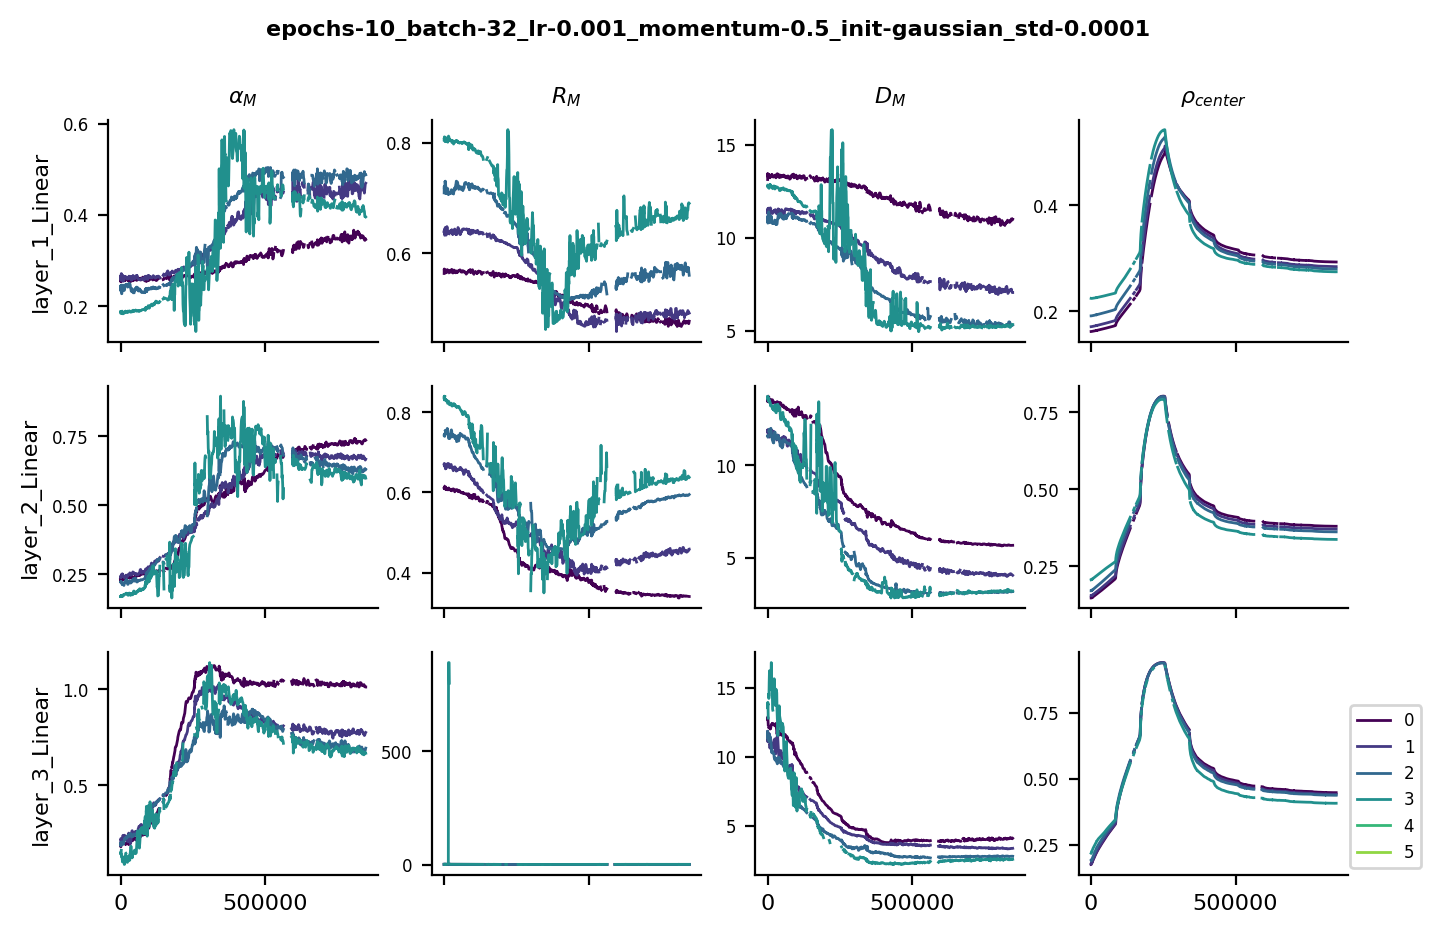

In [161]:
num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

num_hier=np.unique([len(x['mftma']) for x in mftma_res['layer_0_Input']])
num_layers=len(mftma_res.keys())
layer_keys=list(mftma_res.keys())
mftma_keys=['capacities','radii','dimensions','correlations']
fig, axes = plt.subplots(3, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
l_num=1
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\alpha_M$', fontsize=8)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$R_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$D_M$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_title(r'$\rho_{center}$', fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

   
    
# plot layer 2 results
l_num=2
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

   

# plot layer 2 results
l_num=3
layer_data=mftma_res[layer_keys[l_num]]
layer_mftma=[x['mftma'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_corres=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]

layer_cap=np.squeeze(np.stack([[y['capacities']for y in x] for x in layer_mftma]))
layer_rad=np.squeeze(np.stack([[y['radii']for y in x] for x in layer_mftma]))
layer_dim=np.squeeze(np.stack([[y['dimensions']for y in x] for x in layer_mftma]))
layer_corr=np.squeeze(np.stack([[y['correlations']for y in x] for x in layer_mftma]))
corrected_cap=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_rad=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_dim=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
corrected_cor=list(np.empty((epoch_batch.shape[0],layer_cap.shape[1]))*np.NaN)
for idx, x in enumerate(array_corres):
    corrected_cap[int(x)]=layer_cap[idx,:]
    corrected_rad[int(x)]=layer_rad[idx,:]
    corrected_dim[int(x)]=layer_dim[idx,:]
    corrected_cor[int(x)]=layer_corr[idx,:]

ax=axes[(l_num-1)*len(mftma_keys)]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_cap)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.set_ylabel(layer_keys[l_num], fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



ax=axes[(l_num-1)*len(mftma_keys)+1]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_rad)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.axes.xaxis.set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax=axes[(l_num-1)*len(mftma_keys)+2]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_dim)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



ax=axes[(l_num-1)*len(mftma_keys)+3]
for h in range(layer_cap.shape[1]):
    ax.plot(moving_average(np.cumsum(batches),av_window),moving_average(np.stack(corrected_cor)[:,h],av_window),color=line_cols[h,:],label=str(h),linewidth=1)
ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.suptitle(train_identifier,fontsize=8, fontweight='bold')
#plt.tight_layout()
# plt.show()
# fig.savefig(os.path.join(result_dir,analyze_identifier,model_identifier+'_manifold_vals_during_training.png'),transparent=True)
[plt.setp(ax.get_xticklabels(), fontsize=8) for ax in axes]

TypeError: _set_ticklabels() missing 1 required positional argument: 'labels'

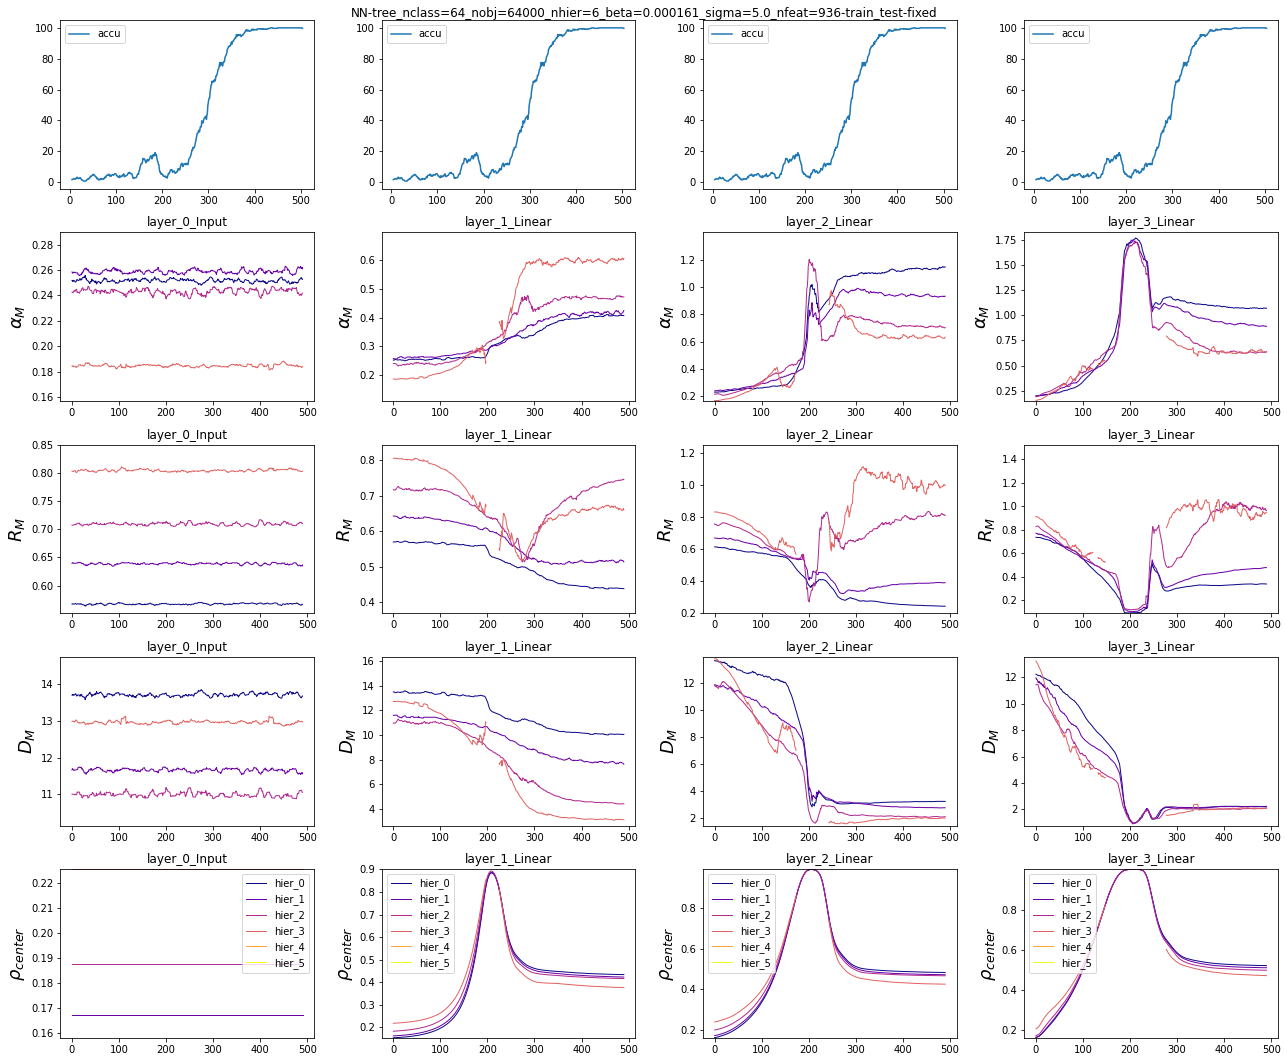

In [35]:
fig, axes = plt.subplots(5, len(mftma_res), figsize=(18, 15))
axes=axes.flatten()
for k in range(4):
    im=axes[k].plot(moving_average(seq,av_window)[:500],moving_average(accu,av_window)[:500])
    axes[k].legend(['accu'])
    #axes[k].set_xlim(min(seq), max(seq))
for j, key in enumerate(mftma_res.keys()):
    mftma=[x['mftma'] for x in mftma_res[key]]
    layer_cap=[[x['capacities'] for x in y] for y in mftma]
    layer_cap=np.stack(layer_cap).squeeze()   
    h0=cm.get_cmap('plasma_r',(layer_cap.shape[1]))
    h0_c=np.flipud(h0(np.arange(layer_cap.shape[1])/layer_cap.shape[1]))
    for i in range(layer_cap.shape[1]):
            im=axes[4+j].plot(moving_average(layer_cap[:500,i],av_window),color=h0_c[i,:],linewidth=1,label='hier_'+str(i))
    axes[4+j].set_ylabel(r'$\alpha_M$', fontsize=18)
    #axes[4+j].set_xlim(min(seq), max(seq))
    axes[4+j].set_ylim(np.nanmin(layer_cap),np.nanmax(layer_cap))
    #axes[4+j].legend()
    axes[4+j].set_title(key)
    #fig.colorbar(im, ax=axes[4*(k+1)])

idx=8
for j, key in enumerate(mftma_res.keys()):
    mftma=[x['mftma'] for x in mftma_res[key]]
    layer_cap=[[x['radii'] for x in y] for y in mftma]
    layer_cap=np.stack(layer_cap).squeeze()   
    h0=cm.get_cmap('plasma_r',(layer_cap.shape[1]))
    h0_c=np.flipud(h0(np.arange(layer_cap.shape[1])/layer_cap.shape[1]))
    for i in range(layer_cap.shape[1]):
            im=axes[idx+j].plot(moving_average(layer_cap[:500,i],av_window),color=h0_c[i,:],linewidth=1,label='hier_'+str(i))
    axes[idx+j].set_ylabel(r'$R_M$', fontsize=18)
    #axes[idx+j].set_xlim(min(seq), max(seq))
    axes[idx+j].set_ylim(np.nanmin(layer_cap),np.nanmax(layer_cap))

    axes[idx+j].set_title(key)

idx=12
for j, key in enumerate(mftma_res.keys()):
    mftma=[x['mftma'] for x in mftma_res[key]]
    layer_cap=[[x['dimensions'] for x in y] for y in mftma]
    layer_cap=np.stack(layer_cap).squeeze()   
    h0=cm.get_cmap('plasma_r',(layer_cap.shape[1]))
    h0_c=np.flipud(h0(np.arange(layer_cap.shape[1])/layer_cap.shape[1]))
    for i in range(layer_cap.shape[1]):
            im=axes[idx+j].plot(moving_average(layer_cap[:500,i],av_window),color=h0_c[i,:],linewidth=1,label='hier_'+str(i))
    axes[idx+j].set_ylabel(r'$D_M$', fontsize=18)
    #axes[idx+j].set_xlim(min(seq), max(seq))
    axes[idx+j].set_ylim(np.nanmin(layer_cap),np.nanmax(layer_cap))
    
    axes[idx+j].set_title(key)

idx=16
for j, key in enumerate(mftma_res.keys()):
    mftma=[x['mftma'] for x in mftma_res[key]]
    layer_cap=[[x['correlations'] for x in y] for y in mftma]
    layer_cap=np.stack(layer_cap).squeeze()   
    h0=cm.get_cmap('plasma_r',(layer_cap.shape[1]))
    h0_c=np.flipud(h0(np.arange(layer_cap.shape[1])/layer_cap.shape[1]))
    for i in range(layer_cap.shape[1]):
            im=axes[idx+j].plot(moving_average(layer_cap[:500,i],av_window),color=h0_c[i,:],linewidth=1,label='hier_'+str(i))
    axes[idx+j].set_ylabel(r'$\rho_{center}$', fontsize=18)
    #axes[idx+j].set_xlim(min(seq), max(seq))
    axes[idx+j].set_ylim(np.nanmin(layer_cap),np.nanmax(layer_cap))
    axes[idx+j].legend()
    axes[idx+j].set_title(key)

plt.suptitle(model_identifier)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(result_dir,analyze_identifier,model_identifier+'_hierarchy_vals_during_training.png'),transparent=True)

# training accurary for different sigma and beta 

In [8]:
from utils import save_dir, analyze_dir

In [21]:
struct_list=['partition','tree']
nhier=[1,6]
beta=[0.0, 0.016, 0.033, 0.05]
sigma=[0.0, 0.833, 1.667, 2.5]
nclass=[64,96]
model_train_test_acc=[]
for b in beta:
    for s in sigma:
        for n in nclass:
            for idx , struct in enumerate(struct_list):
                model=f"NN-{struct_list[idx]}_nclass={n}_nobj={n * 1000}_nhier={nhier[idx]}_beta={b}_sigma={s}_nfeat=3072-train_test-fixed"
                model_train_acc=f'acc_train_{model}.csv'
                model_test_acc=f'acc_test_{model}.csv'
                train=open(os.path.join(save_dir,model,model_train_acc),'r')
                train_lines=[float(x) for x in train.read().splitlines()]
                train.flush()
                test=open(os.path.join(save_dir,model,model_test_acc),'r')
                test_lines=[float(x) for x in test.read().splitlines()]
                test.flush()

                model_train_test_acc.append(dict(beta=b,sigma=s,nclass=n,structure=struct,n_hier=nhier[idx],name=model,train_acc=train_lines,test_acc=test_lines))

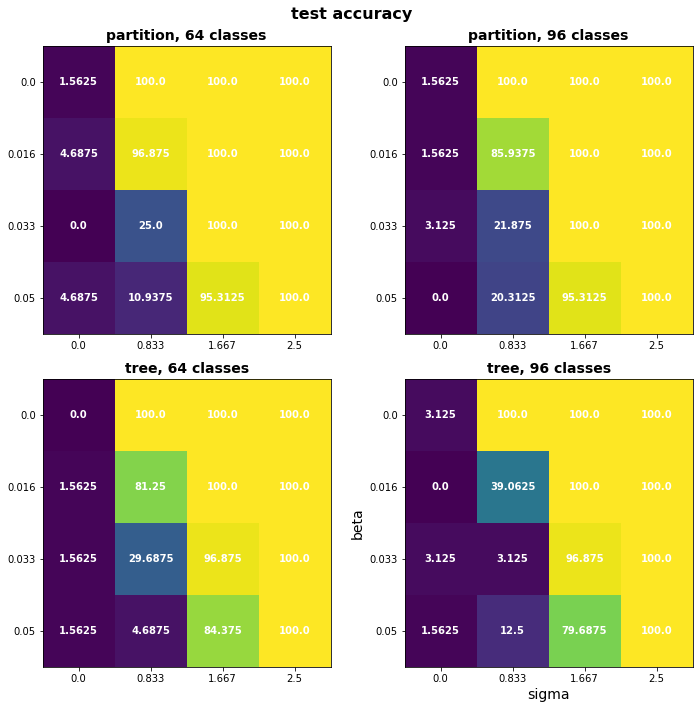

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes=axes.flatten()
st='partition'
ncl=64
ax=axes[0]
data=[(x['beta'],x['sigma'],x['train_acc'][-1],x['test_acc'][-1]) for x in model_train_test_acc if x['structure']==st and x['nclass']==ncl ]
b_val=np.asarray(data)[:,0].reshape(4,4)
s_val=np.asarray(data)[:,1].reshape(4,4)
test_val=np.asarray(data)[:,3].reshape(4,4)
ax.imshow(test_val)
ax.set_xticks(np.arange(s_val.shape[0]))
ax.set_yticks(np.arange(b_val.shape[0]))
ax.set_xticklabels(s_val.mean(axis=0))
ax.set_yticklabels(b_val.mean(axis=1))
for i in range(b_val.shape[0]):
    for j in range(s_val.shape[0]):
        text = ax.text(j, i, test_val[i, j],
                       ha="center", va="center", color="w",fontweight='bold')
ax.set_title(f'{st}, {ncl} classes',fontsize=14,fontweight='bold')


st='partition'
ncl=96
ax=axes[1]
data=[(x['beta'],x['sigma'],x['train_acc'][-1],x['test_acc'][-1]) for x in model_train_test_acc if x['structure']==st and x['nclass']==ncl ]
b_val=np.asarray(data)[:,0].reshape(4,4)
s_val=np.asarray(data)[:,1].reshape(4,4)
test_val=np.asarray(data)[:,3].reshape(4,4)
ax.imshow(test_val)
ax.set_xticks(np.arange(s_val.shape[0]))
ax.set_yticks(np.arange(b_val.shape[0]))
ax.set_xticklabels(s_val.mean(axis=0))
ax.set_yticklabels(b_val.mean(axis=1))
for i in range(b_val.shape[0]):
    for j in range(s_val.shape[0]):
        text = ax.text(j, i, test_val[i, j],
                       ha="center", va="center", color="w",fontweight='bold')
ax.set_title(f'{st}, {ncl} classes',fontsize=14,fontweight='bold')


st='tree'
ncl=64
ax=axes[2]
data=[(x['beta'],x['sigma'],x['train_acc'][-1],x['test_acc'][-1]) for x in model_train_test_acc if x['structure']==st and x['nclass']==ncl ]
b_val=np.asarray(data)[:,0].reshape(4,4)
s_val=np.asarray(data)[:,1].reshape(4,4)
test_val=np.asarray(data)[:,3].reshape(4,4)
ax.imshow(test_val)
ax.set_xticks(np.arange(s_val.shape[0]))
ax.set_yticks(np.arange(b_val.shape[0]))
ax.set_xticklabels(s_val.mean(axis=0))
ax.set_yticklabels(b_val.mean(axis=1))
for i in range(b_val.shape[0]):
    for j in range(s_val.shape[0]):
        text = ax.text(j, i, test_val[i, j],
                       ha="center", va="center", color="w",fontweight='bold')
ax.set_title(f'{st}, {ncl} classes',fontsize=14,fontweight='bold')

st='tree'
ncl=96
ax=axes[3]
data=[(x['beta'],x['sigma'],x['train_acc'][-1],x['test_acc'][-1]) for x in model_train_test_acc if x['structure']==st and x['nclass']==ncl ]
b_val=np.asarray(data)[:,0].reshape(4,4)
s_val=np.asarray(data)[:,1].reshape(4,4)
test_val=np.asarray(data)[:,3].reshape(4,4)
ax.imshow(test_val)
ax.set_xticks(np.arange(s_val.shape[0]))
ax.set_yticks(np.arange(b_val.shape[0]))
ax.set_xticklabels(s_val.mean(axis=0))
ax.set_yticklabels(b_val.mean(axis=1))
for i in range(b_val.shape[0]):
    for j in range(s_val.shape[0]):
        text = ax.text(j, i, test_val[i, j],
                       ha="center", va="center", color="w",fontweight='bold')
ax.set_title(f'{st}, {ncl} classes',fontsize=14,fontweight='bold')

ax.set_xlabel('sigma',fontsize=14)
ax.set_ylabel('beta',fontsize=14)
plt.suptitle('test accuracy',fontsize=16,fontweight='bold')
fig.tight_layout()

if not os.path.exists(os.path.join(result_dir,'training_result')):
        os.mkdir(os.path.join(result_dir,'training_result'))
fig.savefig(os.path.join(result_dir,'training_result',f'test_accu_structures:partition,tree_betas:{b_val.min()},{b_val.max()}_sigmas:{s_val.min()},{s_val.max()}.png'),transparent=True)